### Contact on balls outside strike zone

$$\text{inv_path} = \left(1-\frac{\text{path}}{\text{batter_multiplier}}\right) \times (1+0.2 \times \text{batter_vibes})$$

$$\text{ballpark_sum} = \frac{(\text{fort} - 0.5) + 3 \times (\text{visc} - 0.5) - 6 \times (\text{fwd} - 0.5)}{10}$$

$$\text{threshold}_{\text{s12s13}} = 0.35 - 0.1 \times \text{ruth} + 0.4 \times \text{inv_path} ^ {1.5} + 0.14 \times \text{ballpark_sum}$$

$$\text{threshold}_{\text{s14s15}} = 0.4 - 0.1 \times \text{ruth} + 0.35 \times \text{inv_path} ^ {1.5} + 0.14 \times \text{ballpark_sum}$$


$\text{ruth}$ is standard pitcher ruthlessness with 20% vibes and multiplier.

In [1]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE
from csv_dtypes import column_dtypes
all_files = glob.glob("../roll_data/*-contact.csv")

df = pd.concat((pd.read_csv(f, dtype=column_dtypes) for f in all_files), ignore_index=True)

seasons = [11, 12, 13, 14]
df = df[df['season'].isin(seasons)]
len(df)

432772

In [2]:
def get_pitcher_mul(row):
    pm = str(row["pitcher_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in pm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in pm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        # ignore for ruthlessness
        pass
    if "HIGH_PRESSURE" in ptm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "GROWTH" in ptm:
        # ignore for ruthlessness
        pass
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    return mul


def get_batter_mul(row):
    # if row[["batter_name"]].isna().any():
    # row["batter_name"] == "NaaN"
    bm = str(row["batter_mods"])
    btm = str(row["batting_team_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    attrs = ""
    if "OVERPERFORMING" in bm:
        mul += 0.2
    if "OVERPERFORMING" in btm:
        mul += 0.2
    if "UNDERPERFORMING" in bm:
        mul -= 0.2
    if "UNDERPERFORMING" in btm:
        mul -= 0.2
    if "TRAVELING" in btm:
        # ignore for patheticism
        pass
    if "GROWTH" in btm:
        # ignore for patheticism
        pass
    if "HIGH_PRESSURE" in btm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "SINKING_SHIP" in btm:
        mul += (14 - row["batting_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in btm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    if "MINIMALIST" in bm and row["ball_count"] == 3 and row["strike_count"] == 2 and row["baserunner_count"] == 3:
        mul -= 0.75
    # if "CHUNKY" in bm and row["weather"] == "Weather.PEANUTS":
        # todo: make this work if there's also, like, Overperforming active
        # it only should apply to "power" attrs
        # mul += 1.0
        # attrs = "batter_musclitude, batter_divinity, batter_ground_friction"
    # if "SMOOTH" in bm and row["weather"] == "Weather.PEANUTS":
        # todo: make this work if there's also, like, Overperforming active
        # it only should apply to "speed" attrs
        # doing 80% because of evidence from the Spin Attack blessing that "speed"
        # boosts laserlikeness 80% of what it says the total boost is?
        # mul += 0.80
        # attrs = "batter_musclitude, batter_laserlikeness, batter_ground_friction, batter_continuation"
    # if "ON_FIRE" in bm:
        # todo: handle
        # test "+125% multiplier"
        # mul += 1.25
        # pass
    # NVGs real??? eclipse weather, special case for Sutton Dreamy
    # surely this will not break from scattering, right? (It totally will)
    # if row["batter_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
    # NVGs allow the player to play 50% better in a solar eclipse.
    # This might affect fielding and baserunning as well?
    # mul += 0.50
    return mul


def get_fielder_mul(row):
    fm = str(row["fielder_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in fm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in fm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        # pass
        if not row["top_of_inning"]:
            mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        if row["weather"] == 18 and row["baserunner_count"] > 0:
            mul += 0.25
    if "GROWTH" in ptm:
        mul += min(0.05, 0.05 * (row["day"] / 99))
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    if "SHELLED" in fm:
        # is it this, or is it "mul = 0", I wonder
        mul -= 1.0
    # if row["fielder_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
    # NVGs allow the player to play 50% better in a solar eclipse.
    # This might affect fielding and baserunning as well?
    # mul += 0.50
    return mul

In [3]:
df["batter_mul"] = df.apply(get_batter_mul, axis=1)
df["pitcher_mul"] = df.apply(get_pitcher_mul, axis=1)

In [4]:
df.loc[df["pitcher_mods"].astype(str).str.contains("SCATTERED"), "pitcher_vibes"] = 0
df.loc[df["batter_mods"].astype(str).str.contains("SCATTERED"), "batter_vibes"] = 0
df.loc[df["fielder_mods"].astype(str).str.contains("SCATTERED"), "fielder_vibes"] = 0

In [32]:
dfc = df.copy()
dfc = dfc[dfc["is_strike"] == False]

# dfc = dfc[~((dfc["season"] == 11) & (dfc["day"] == 98))] # bad data here

for exclude_mod in []:#["GROWTH", "TRAVELING", "SHELLED", "CHUNKY", "SMOOTH"]:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["fielder_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]

dfc = dfc[~(dfc["batting_team_mods"].astype(str).str.contains("O_NO") & (dfc["ball_count"] == 0))]

In [33]:
dfc["inv_path"] = (1 - (dfc["batter_patheticism"] / dfc["batter_mul"])) * (1 + 0.2*dfc["batter_vibes"])
dfc.loc[dfc["inv_path"]< 0, "inv_path"] = 0
dfc["inv_path_pow"] = (dfc["inv_path"] ** 1.5)
dfc["ruth"] = dfc["pitcher_ruthlessness"] * (1 + 0.2*dfc["pitcher_vibes"]) * dfc["pitcher_mul"]

dfc["grand_center"] = dfc["ballpark_grandiosity"] - 0.5
dfc["fort_center"] = dfc["ballpark_fortification"] - 0.5
dfc["obt_center"] = dfc["ballpark_obtuseness"] - 0.5
dfc["om_center"] = dfc["ballpark_ominousness"] - 0.5
dfc["inc_center"] = dfc["ballpark_inconvenience"] - 0.5
dfc["visc_center"] = dfc["ballpark_viscosity"] - 0.5
dfc["fwd_center"] = dfc["ballpark_forwardness"] - 0.5
dfc["myst_center"] = dfc["ballpark_mysticism"] - 0.5
dfc["elong_center"] = dfc["ballpark_elongation"] - 0.5

dfc.loc[dfc["season"] == 11,"inv_path_pow_season"] = dfc["inv_path_pow"] * 0.4
dfc.loc[dfc["season"] == 12,"inv_path_pow_season"] = dfc["inv_path_pow"] * 0.4
dfc.loc[dfc["season"] == 13,"inv_path_pow_season"] = dfc["inv_path_pow"] * 0.35
dfc.loc[dfc["season"] == 14,"inv_path_pow_season"] = dfc["inv_path_pow"] * 0.35

dfc["ballpark_sum"] = (dfc["fort_center"] + 3*dfc["visc_center"] - 6*dfc["fwd_center"]) / 10

# we know the intercept is 0.4 in s12/s13 and 0.35 in s14/s15 so special case it here so the fit works across
dfc.loc[dfc["season"] == 13,"roll"] -= 0.05
dfc.loc[dfc["season"] == 14,"roll"] -= 0.05

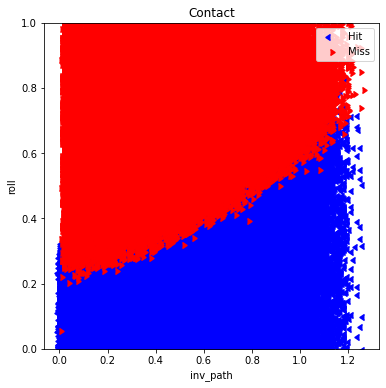

In [34]:
x_val = "inv_path"
y_val = "roll"
fig, ax = plt.subplots(1, figsize=(6, 6))
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]][y_val],
    color="blue",
    label="Hit",
    marker=CARETLEFTBASE,
)
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]][y_val],
    color="red",
    label="Miss",
    marker=CARETRIGHTBASE,
)

ax.set_xlabel(x_val)
ax.set_ylabel("roll")
ax.set_title(f"Contact")
ax.set_ylim(0, 1)

if x_val == "threshold":
    ax.plot(ax.get_xlim(), ax.get_xlim())

ax.legend()

In [35]:
dfc.loc[dfc["inv_path"] <= 0, [
        "passed",
        "event_type",
        # "offset",
        "roll",
        # "threshold",
        "batter_patheticism",
        "inv_path",
        "ruth",

        "ballpark_sum",
        "pitcher_mul",
        "batter_mul",
        "batter_name",
        "pitcher_name",
        "batter_mods",
        "pitcher_mods",
        "batting_team_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
        "ball_count",
        "strike_count",
        "weather",
    ]]

,passed,event_type,roll,batter_patheticism,inv_path,ruth,ballpark_sum,pitcher_mul,batter_mul,batter_name,pitcher_name,batter_mods,pitcher_mods,batting_team_mods,pitching_team_mods,season,day,game_id,play_count,ball_count,strike_count,weather
234787,False,StrikeSwinging,0.055271,0.272384,0.0,0.528893,-0.066775,1.0,0.25,Beasley Day,Bright Zimmerman,MINIMALIST,WANDERER,AFFINITY_FOR_CROWS,TRAVELING,14,47,65949d33-9b8f-4422-9b63-70af548e1fbf,262,3,2,Weather.BLACK_HOLE
339457,True,BaseHit,0.110704,0.851489,0.0,0.872369,-0.017714,1.0,0.80,Moses Mason,Sixpack Santiago,ALTERNATE;UNDERPERFORMING;SCATTERED;RECEIVER;C...,<NA>,GROWTH,ELECTRIC;LIFE_OF_PARTY,13,80,edac002e-77f8-4aa7-8754-f341f2f42b08,112,0,1,Weather.FEEDBACK
339853,True,Out,0.231290,0.851489,0.0,0.872369,-0.017714,1.0,0.80,Moses Mason,Sixpack Santiago,UNDERPERFORMING;RECEIVER;SMOOTH,<NA>,GROWTH,ELECTRIC;LIFE_OF_PARTY,13,80,edac002e-77f8-4aa7-8754-f341f2f42b08,212,0,2,Weather.FEEDBACK
340151,False,StrikeSwinging,0.337183,0.851489,0.0,0.872369,-0.017714,1.0,0.80,Moses Mason,Sixpack Santiago,UNDERPERFORMING;FIRE_EATER;RECEIVER,<NA>,GROWTH,ELECTRIC;LIFE_OF_PARTY,13,80,edac002e-77f8-4aa7-8754-f341f2f42b08,326,0,0,Weather.FEEDBACK
340152,False,StrikeSwinging,0.884524,0.851489,0.0,0.872369,-0.017714,1.0,0.80,Moses Mason,Sixpack Santiago,UNDERPERFORMING;FIRE_EATER;RECEIVER,<NA>,GROWTH,ELECTRIC;LIFE_OF_PARTY,13,80,edac002e-77f8-4aa7-8754-f341f2f42b08,327,0,1,Weather.FEEDBACK
340259,False,StrikeSwinging,0.493516,0.851489,0.0,0.872369,-0.017714,1.0,0.80,Moses Mason,Sixpack Santiago,UNDERPERFORMING;FIRE_EATER;RECEIVER,<NA>,GROWTH,ELECTRIC;LIFE_OF_PARTY,13,80,edac002e-77f8-4aa7-8754-f341f2f42b08,415,0,1,Weather.FEEDBACK
340261,True,Out,0.050636,0.851489,0.0,0.872369,-0.017714,1.0,0.80,Moses Mason,Sixpack Santiago,UNDERPERFORMING;FIRE_EATER;RECEIVER,<NA>,GROWTH,ELECTRIC;LIFE_OF_PARTY,13,80,edac002e-77f8-4aa7-8754-f341f2f42b08,416,0,2,Weather.FEEDBACK


In [36]:
X = dfc[
    [
        "roll",
        "season",
        "passed",
        "inv_path_pow_season",
        "ruth",

        "ballpark_sum",
    ]
].copy()

X = X[~X["inv_path_pow_season"].isna()].copy()

pin_intercept = None
pin_intercept = 0.35
pins = [
    (-0.1, "ruth"),
    (1, "inv_path_pow_season"),
    (0.14, "ballpark_sum"),
]
for val, var in pins:
    X["roll"] -= X[var] * val
    X = X.drop(var, axis=1)

y = X["passed"]
X = X.drop(["passed", "season"], axis=1)

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model


sc = StandardScaler(with_mean=False)
X2 = sc.fit_transform(X)
if pin_intercept is not None:
    X2[:,0] -= pin_intercept / sc.scale_[0]

trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=100000000, tol=1e-12, fit_intercept=pin_intercept is None).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))
print(trainedsvm.score(X2, y))

[[56269     1]
 [    0 47539]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     56270
        True       1.00      1.00      1.00     47539

    accuracy                           1.00    103809
   macro avg       1.00      1.00      1.00    103809
weighted avg       1.00      1.00      1.00    103809

0.9999903669238698


In [38]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_# - np.dot(coef, sc.mean_)
intercept_scaled = pin_intercept or -(intercept / coef[0, 0])[0]

dfc["threshold"] = intercept_scaled
print("intercept:", intercept_scaled)
for pair in pins + list(zip(-np.array(coef_list), X.columns)):
    if pair[1] != "roll":
        print(pair)
        dfc["threshold"] += pair[0] * dfc[pair[1]]


intercept: 0.35
(-0.1, 'ruth')
(1, 'inv_path_pow_season')
(0.14, 'ballpark_sum')


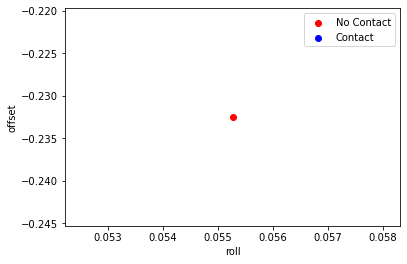

In [39]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]

fig, ax = plt.subplots(1)
x_val = "roll"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["offset"],
    color="red",
    label="No Contact",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Contact",
)
ax.set_xlabel(x_val)
ax.set_ylabel("offset")
ax.legend()

In [40]:
pd.set_option("display.max_columns", None)
table = outliers[
    [
        "passed",
        "event_type",
        "offset",
        "roll",
        "threshold",
        "pitcher_mul",
        "batter_mul",
        "batter_name",
        "pitcher_name",
        "batter_mods",
        "pitcher_mods",
        "batting_team_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
        "ball_count",
        "strike_count",
        "weather",
    ]
]
print(len(table))
table.sort_values("offset", ascending=False)#[0:10]

1


,passed,event_type,offset,roll,threshold,pitcher_mul,batter_mul,batter_name,pitcher_name,batter_mods,pitcher_mods,batting_team_mods,pitching_team_mods,season,day,game_id,play_count,ball_count,strike_count,weather
234787,False,StrikeSwinging,-0.232491,0.055271,0.287762,1.0,0.25,Beasley Day,Bright Zimmerman,MINIMALIST,WANDERER,AFFINITY_FOR_CROWS,TRAVELING,14,47,65949d33-9b8f-4422-9b63-70af548e1fbf,262,3,2,Weather.BLACK_HOLE


In [44]:
dfc.loc[dfc["inv_path"] <= 0, [
        "passed",
        "event_type",
        "offset",
        "roll",
        "threshold",
        "batter_patheticism",
        "inv_path",
        "ruth",
        "ballpark_sum",
        "pitcher_mul",
        "batter_mul",
        "batter_name",
        "pitcher_name",
        "batter_mods",
        "pitcher_mods",
        "batting_team_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
        "ball_count",
        "strike_count",
        "out_count",
        "baserunner_count",
        "weather",
    ]]

,passed,event_type,offset,roll,threshold,batter_patheticism,inv_path,ruth,ballpark_sum,pitcher_mul,batter_mul,batter_name,pitcher_name,batter_mods,pitcher_mods,batting_team_mods,pitching_team_mods,season,day,game_id,play_count,ball_count,strike_count,out_count,baserunner_count,weather
234787,False,StrikeSwinging,-0.232491,0.055271,0.287762,0.272384,0.0,0.528893,-0.066775,1.0,0.25,Beasley Day,Bright Zimmerman,MINIMALIST,WANDERER,AFFINITY_FOR_CROWS,TRAVELING,14,47,65949d33-9b8f-4422-9b63-70af548e1fbf,262,3,2,2,3,Weather.BLACK_HOLE
339457,True,BaseHit,-0.149579,0.110704,0.260283,0.851489,0.0,0.872369,-0.017714,1.0,0.80,Moses Mason,Sixpack Santiago,ALTERNATE;UNDERPERFORMING;SCATTERED;RECEIVER;C...,<NA>,GROWTH,ELECTRIC;LIFE_OF_PARTY,13,80,edac002e-77f8-4aa7-8754-f341f2f42b08,112,0,1,0,0,Weather.FEEDBACK
339853,True,Out,-0.028993,0.231290,0.260283,0.851489,0.0,0.872369,-0.017714,1.0,0.80,Moses Mason,Sixpack Santiago,UNDERPERFORMING;RECEIVER;SMOOTH,<NA>,GROWTH,ELECTRIC;LIFE_OF_PARTY,13,80,edac002e-77f8-4aa7-8754-f341f2f42b08,212,0,2,0,0,Weather.FEEDBACK
340151,False,StrikeSwinging,0.076900,0.337183,0.260283,0.851489,0.0,0.872369,-0.017714,1.0,0.80,Moses Mason,Sixpack Santiago,UNDERPERFORMING;FIRE_EATER;RECEIVER,<NA>,GROWTH,ELECTRIC;LIFE_OF_PARTY,13,80,edac002e-77f8-4aa7-8754-f341f2f42b08,326,0,0,2,2,Weather.FEEDBACK
340152,False,StrikeSwinging,0.624241,0.884524,0.260283,0.851489,0.0,0.872369,-0.017714,1.0,0.80,Moses Mason,Sixpack Santiago,UNDERPERFORMING;FIRE_EATER;RECEIVER,<NA>,GROWTH,ELECTRIC;LIFE_OF_PARTY,13,80,edac002e-77f8-4aa7-8754-f341f2f42b08,327,0,1,2,2,Weather.FEEDBACK
340259,False,StrikeSwinging,0.233233,0.493516,0.260283,0.851489,0.0,0.872369,-0.017714,1.0,0.80,Moses Mason,Sixpack Santiago,UNDERPERFORMING;FIRE_EATER;RECEIVER,<NA>,GROWTH,ELECTRIC;LIFE_OF_PARTY,13,80,edac002e-77f8-4aa7-8754-f341f2f42b08,415,0,1,2,1,Weather.FEEDBACK
340261,True,Out,-0.209647,0.050636,0.260283,0.851489,0.0,0.872369,-0.017714,1.0,0.80,Moses Mason,Sixpack Santiago,UNDERPERFORMING;FIRE_EATER;RECEIVER,<NA>,GROWTH,ELECTRIC;LIFE_OF_PARTY,13,80,edac002e-77f8-4aa7-8754-f341f2f42b08,416,0,2,2,1,Weather.FEEDBACK


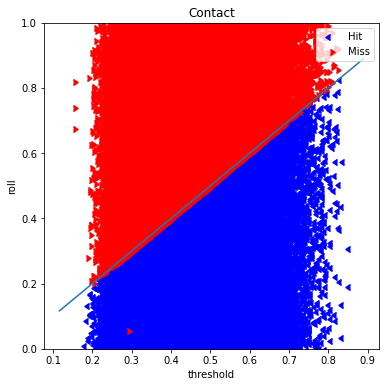

In [42]:
x_val = "threshold"
y_val = "roll"
fig, ax = plt.subplots(1, figsize=(6, 6))
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]][y_val],
    color="blue",
    label="Hit",
    marker=CARETLEFTBASE,
)
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]][y_val],
    color="red",
    label="Miss",
    marker=CARETRIGHTBASE,
)

ax.set_xlabel(x_val)
ax.set_ylabel("roll")
ax.set_title(f"Contact")
ax.set_ylim(0, 1)

if x_val == "threshold":
    ax.plot(ax.get_xlim(), ax.get_xlim())

ax.legend()